In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat as stat
import seaborn as sns
from pathlib import Path
import re

In [2]:
data_dir = Path("/Users/adamcartwright/ncerdc/Student Data/Testing Data")
years    = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# map typo’d names → correct names
rename_map = {
    'sat_erw_score_hc': 'sat_ebrw_score_hc',
    'sat_erw_score_mr': 'sat_ebrw_score_mr',
    'sat_ctsh_ss_mc':   'sat_ctsh_ss_hc',
    'ital':           'italgr'
}

# --- 1) Build “first-seen” list of all columns ---
seen = []
for yr in years:
    hdr = pd.read_csv(
        data_dir / f"collegeboard{str(yr)[-2:]}pub.csv",
        nrows=0
    )
    cols = (
        hdr.columns
           .str.strip()
           .str.lower()
           .str.replace(" ", "_")
           .map(lambda c: rename_map.get(c, c))
    )
    for c in cols:
        if c not in seen:
            seen.append(c)

all_cols = seen  # preserves 2018 order, then new 2019 fields, etc.

# --- 2) Read & clean each year’s data, align to all_cols ---
dfs = []
for yr in years:
    df = pd.read_csv(
        data_dir / f"collegeboard{str(yr)[-2:]}pub.csv",
        low_memory=False
    )
    # normalize original column names
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(" ", "_")
    )
    # fix known typos
    df = df.rename(columns=rename_map)
    # drop any duplicate columns just in case
    df = df.loc[:, ~df.columns.duplicated()]
    # reindex so every DF has exactly all_cols (missing→NaN)
    df = df.reindex(columns=all_cols)
    # tag the year
    df['year'] = yr

    dfs.append(df)

# --- 3) Concatenate into one clean DataFrame ---
cb = pd.concat(dfs, ignore_index=True)

# find all the float columns
float_cols = cb.select_dtypes(include='float').columns
cb[float_cols] = cb[float_cols].round().astype('Int64')

date_cols = [c for c in cb.columns 
             if c in ['birthdt', 'grad_date'] 
             or c.endswith('_dt')]

# convert
for col in date_cols:
    cb[col] = pd.to_datetime(cb[col], errors='coerce')
    
cat_cols = [
    'sex',       # e.g. M/F
    'ethnic',    # your coded ethnicity groups
    'blang',     # bilingual flag
    'lea',       # local education agency code
    'instname'   # school name
]

for col in cat_cols:
    if col in cb.columns:
        cb[col] = cb[col].astype('category')
        
essay_cols = ['sat_er_hc', 'sat_er_mr', 'sat_ea_hc', 'sat_ea_mr', 'sat_ew_hc', 'sat_ew_mr']
cb = cb.drop(columns=[c for c in essay_cols if c in cb.columns])

cb['birthdt'] = cb['birthdt'].replace(r'^\s*$', np.nan, regex=True)
cb['lea']      = cb['lea'].replace(['<NA>', 'nan'], np.nan)
cb['schlcode'] = cb['schlcode'].replace(['<NA>', 'nan'], np.nan)

# 2) Drop any rows missing birthdt, lea, or schlcode
cb = cb.dropna(subset=['birthdt', 'lea', 'schlcode'])

cb['lea'] = cb['lea'].astype(str).str.strip()

cb['schlcode'] = cb['schlcode'].astype(str).str.zfill(3)
cb['school_id'] = (
    cb['lea'].astype(str)
    + '-'
    + cb['schlcode'].astype(str)
)






In [3]:
# 1. Define your “total” columns explicitly
psat_totals = [
    'psat_8_9_total',
    'psat_nmsqt_total',
    'psat_10_total'
]
sat_totals = [
    'sat_total_score_mr',
    'sat_total_score_hc'
]

# 2. Identify your AP‐grade columns by the “gr” suffix
ap_score_cols = [c for c in cb.columns if re.match(r'.+gr$', c)]

# 3. Utility to find out‐of‐range values
def find_out_of_range(df, cols, lo, hi):
    bad = {}
    for c in cols:
        mask = df[c].notna() & ~df[c].between(lo, hi)
        if mask.any():
            bad[c] = df.loc[mask, c].unique()
    return bad

# 4. Run the checks
bad_ap        = find_out_of_range(cb, ap_score_cols,   1,    5)
bad_psat      = find_out_of_range(cb, psat_totals,     240, 1520)
bad_sat       = find_out_of_range(cb, sat_totals,      400, 1600)

# 5. Report
print("AP grades outside 1–5:",         bad_ap)
print("PSAT total scores outside 240–1520:", bad_psat)
print("SAT total scores outside 400–1600:",  bad_sat)

print(len(cb.columns))
print(cb.columns.tolist())



AP grades outside 1–5: {}
PSAT total scores outside 240–1520: {}
SAT total scores outside 400–1600: {}
136
['birthdt', 'sex', 'grad_date', 'ethnic', 'blang', 'instname', 'psat_8_9_test_dt', 'psat_8_9_total', 'psat_8_9_ebrw', 'psat_8_9_math', 'psat_8_9_tsr', 'psat_8_9_tsw', 'psat_8_9_tsm', 'psat_8_9_sub_evid', 'psat_8_9_sub_cont', 'psat_8_9_sub_expr', 'psat_8_9_sub_conv', 'psat_8_9_sub_alge', 'psat_8_9_sub_prob', 'psat_8_9_ctsh', 'psat_8_9_ctss', 'psat_test_dt', 'psat_nmsqt_total', 'psat_nmsqt_ebrw', 'psat_nmsqt_math', 'psat_nmsqt_tsr', 'psat_nmsqt_tsw', 'psat_nmsqt_tsm', 'psat_nmsqt_sub_evid', 'psat_nmsqt_sub_cont', 'psat_nmsqt_sub_expr', 'psat_nmsqt_sub_conv', 'psat_nmsqt_sub_alge', 'psat_nmsqt_sub_prob', 'psat_nmsqt_sub_advm', 'psat_nmsqt_ctsh', 'psat_nmsqt_ctss', 'psat_10_test_dt', 'psat_10_total', 'psat_10_ebrw', 'psat_10_math', 'psat_10_tsr', 'psat_10_tsw', 'psat_10_tsm', 'psat_10_sub_evid', 'psat_10_sub_cont', 'psat_10_sub_expr', 'psat_10_sub_conv', 'psat_10_sub_alge', 'psat_10_s

In [4]:
cb.to_csv(data_dir/"collegeboard_clean.csv", index=False)

In [5]:
# 2) Parse 'sat_asmt_dt_mr' to datetime, then drop rows without a valid date
cb['sat_asmt_dt_hc'] = pd.to_datetime(cb['sat_asmt_dt_hc'], errors='coerce')
cb = cb.dropna(subset=['sat_asmt_dt_hc'])

# 3) Extract the test year from the assessment date
cb['test_year'] = cb['sat_asmt_dt_hc'].dt.year

# 4) Drop rows missing any of the three SAT_HC raw scores (so percentiles compute correctly)
cb = cb.dropna(subset=['sat_total_score_hc', 'sat_ebrw_score_hc', 'sat_math_score_hc'])

# 5) Compute percentiles within each actual test year
cb['total_percentile'] = (
    cb.groupby('test_year')['sat_total_score_hc']
      .rank(method='average', pct=True) * 100
)
cb['reading_percentile'] = (
    cb.groupby('test_year')['sat_ebrw_score_hc']
      .rank(method='average', pct=True) * 100
)
cb['math_percentile'] = (
    cb.groupby('test_year')['sat_math_score_hc']
      .rank(method='average', pct=True) * 100
)

# 6) Sanity check: show a few rows
print(cb[['sat_asmt_dt_hc', 'test_year',
          'sat_total_score_hc', 'total_percentile',
          'sat_ebrw_score_hc', 'reading_percentile',
          'sat_math_score_hc', 'math_percentile']].head(10))






   sat_asmt_dt_hc  test_year  sat_total_score_hc  total_percentile  \
5      2016-12-03       2016                1040         40.737928   
6      2017-06-03       2017                1080         45.724818   
7      2016-11-05       2016                1260            83.778   
12     2017-06-03       2017                1150         60.674149   
14     2017-05-06       2017                1090         47.947107   
22     2016-10-01       2016                1120         58.929003   
24     2017-06-03       2017                1460         97.313553   
25     2017-01-21       2017                1110          52.39243   
27     2017-05-06       2017                 940         18.555886   
31     2017-05-06       2017                 870          9.279435   

    sat_ebrw_score_hc  reading_percentile  sat_math_score_hc  math_percentile  
5                 540           47.720291                500        32.997964  
6                 500           28.522603                580        6

In [6]:
cb.to_csv(data_dir/"cb_sat_percentiles.csv", index=False)

      count    mean    std  min   25%   50%   75%   max
year                                                   
2017  60748  1101.8  175.1  460   980  1100  1220  1600
2018  64913  1105.4  181.6  400   970  1100  1230  1600
2019  61921  1103.4  181.3  400   970  1100  1230  1600
2020  41003  1101.8  180.1  430   970  1100  1230  1600
2021  29969  1143.6  184.9  500  1020  1140  1270  1600
2022  28503  1136.1  197.9  400  1000  1140  1280  1600


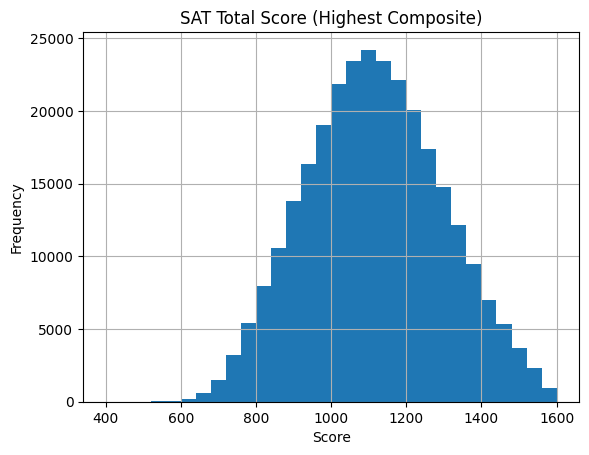

In [7]:
agg_funcs = {
    'count': 'count',
    'mean': 'mean',
    'std': 'std',
    'min': 'min',
    '25%': lambda x: x.quantile(0.25),
    '50%': lambda x: x.quantile(0.50),
    '75%': lambda x: x.quantile(0.75),
    'max': 'max'
}

sat_stats = cb.groupby('year')['sat_total_score_hc'].agg(**agg_funcs).round(1)
print(sat_stats)

plt.figure()
cb['sat_total_score_hc'].hist(bins=30)
plt.title('SAT Total Score (Highest Composite)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Number of AP Exams Taken per Student:
num_ap_taken
0    137026
1     53239
2     45191
3     30213
4     14880
5      5065
6      1195
7       210
8        33
9         5
Name: count, dtype: int64

AP Participation Categories:
ap_participation
multiple     96792
none        137026
one          53239
Name: count, dtype: int64


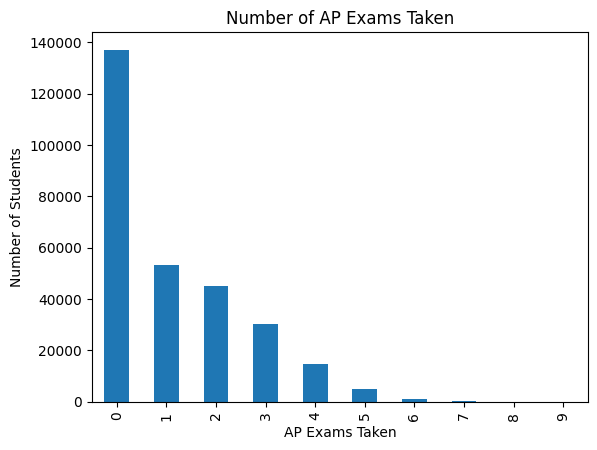

In [8]:
# 1a. pick out your AP‐score columns
ap_cols = [c for c in cb.columns if c.endswith('gr')]

# count how many AP grades each student has
cb['num_ap_taken'] = cb[ap_cols].notna().sum(axis=1)

# bucket for labeling
def ap_bucket(n):
    if n == 0:    return 'none'
    elif n == 1:  return 'one'
    else:         return 'multiple'

cb['ap_participation'] = cb['num_ap_taken']\
                           .apply(ap_bucket)\
                           .astype('category')

counts = cb['num_ap_taken'].value_counts().sort_index()
print("Number of AP Exams Taken per Student:")
print(counts)

bucket_counts = cb['ap_participation'].value_counts().sort_index()
print("\nAP Participation Categories:")
print(bucket_counts)

plt.figure()
cb['num_ap_taken'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of AP Exams Taken')
plt.xlabel('AP Exams Taken')
plt.ylabel('Number of Students')
plt.show()


      psat_8_9_total  psat_nmsqt_total  psat_10_total
year                                                 
2017          1060.0            1130.0         1140.0
2018          1190.0            1120.0         1145.0
2019            <NA>            1140.0         1200.0
2020          1290.0            1170.0         1010.0
2021          1180.0            1150.0         1250.0
2022          1240.0            1100.0          970.0


<Figure size 640x480 with 0 Axes>

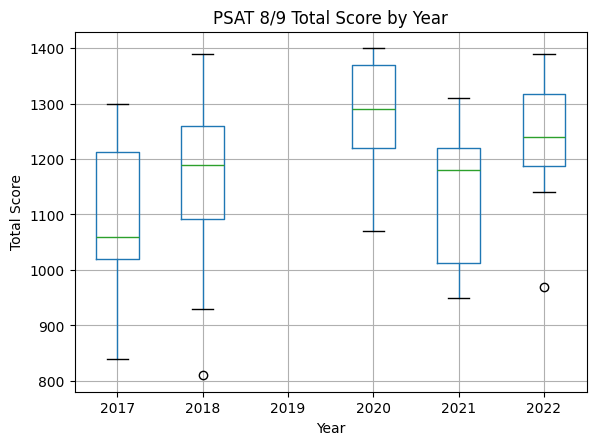

<Figure size 640x480 with 0 Axes>

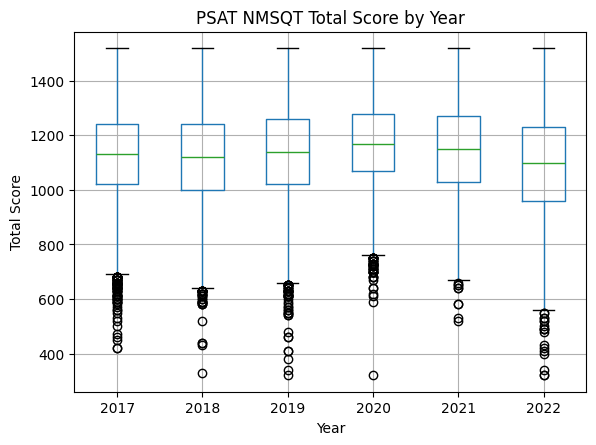

<Figure size 640x480 with 0 Axes>

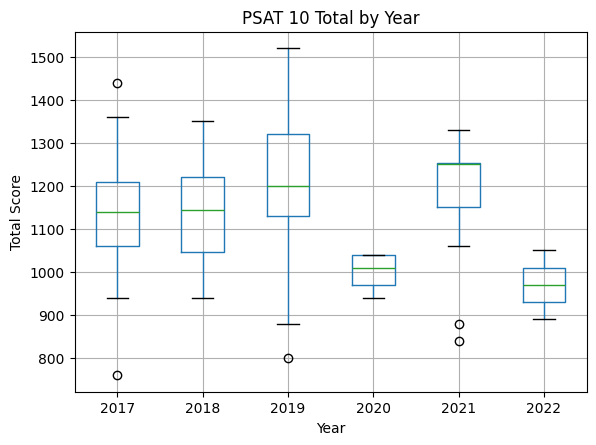

In [9]:
# Compare median total by test type & year
psat = cb[['year','psat_8_9_total','psat_nmsqt_total','psat_10_total']]
print(psat.groupby('year').median().round(0))

# Boxplot of PSAT 8/9 scores
plt.figure()
cb.boxplot(column='psat_8_9_total', by='year')
plt.title('PSAT 8/9 Total Score by Year')
plt.suptitle('')            # remove the auto “Boxplot grouped by year” subtitle
plt.xlabel('Year')
plt.ylabel('Total Score')
plt.show()

# Boxplot of PSAT NMSQT scores
plt.figure()
cb.boxplot(column='psat_nmsqt_total', by='year')
plt.title('PSAT NMSQT Total Score by Year')
plt.suptitle('')
plt.xlabel('Year')
plt.ylabel('Total Score')
plt.show()
# Boxplot of PSAT 10 scores
plt.figure()
cb.boxplot(column='psat_10_total', by='year')
plt.title('PSAT 10 Total by Year')
plt.suptitle('')
plt.xlabel('Year')
plt.ylabel('Total Score')
plt.show()
